# Notebook 42: Trishear inverse modelling

In [Notebook 37](nb37_trishear.ipynb), we introduced the trishear fault propagation folding model. In this notebook, we tackle a more challenging and insightful problem: how to determine the set of trishear model parameters that best fits an actual fold?

Unlike some structural models, trishear lacks direct mathematical relationships to derive parameters from fold geometry. As a result, finding a best-fit model is inherently a trial-and-error process. A set of models is generated and compared against observational data, and the one that most closely matches the data is selected as the solution. The degree of fit is quantified using an objective function, which returns smaller values when the model and data are in closer agreement.

Since trishear can be run forwards and backwards, the objective function can be designed to measure either how well the model restores the fold, or how well the model deforms initial beds to the fold configuration. The restoration approach works well when at least one bed can be traced across the fold. In such case and in 2D, the best model is the one that restores the folded bed back to a straight line ([Allmendinger, 1998](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/98TC01907)).

## Python functions

The [trishear_inv](../functions/trishear_inv.py) module contains functions for 2D trishear inverse modelling. These include:

1. [back_trishear](../functions/trishear_inv.py): Performs backward trishear deformation and returns the misfit between the restored bed and a straight line. This is our objective function.

2. [grid_search](../functions/trishear_inv.py): Brute-force grid-search of the trishear parameters within defined ranges.

3. [simulated_annealing](../functions/trishear_inv.py): Solves for the best-fit trishear parameters using simulated annealing.

4. [restore_beds](../functions/trishear_inv.py): Restores the beds for a set of trishear parameters. It returns linear fits to the restored beds.

5. [deform_beds](../functions/trishear_inv.py): Deforms the beds for a set of trishear parameters.

## Application

Let’s walk through an example. We’ll determine the trishear model that best fits a meter-scale fault propagation fold from the Hudson Valley fold-and-thrust belt, as shown in Figure 16 of [Mitra (1990)](https://pubs.geoscienceworld.org/aapg/aapgbull/article-abstract/74/6/921/38574/Fault-Propagation-Folds-Geometry-Kinematic).

To begin, import the necessary libraries and functions:

In [1]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join("..", "functions")))
from trishear_inv import grid_search, simulated_annealing, restore_beds, deform_beds

The fold data are included in the data/Catskill directory. It contains the x and y coordinates of points along the beds. As an example, this is the lowermost [bed 1](../data/Catskill/bed1.txt).

Let's read and plot the data:

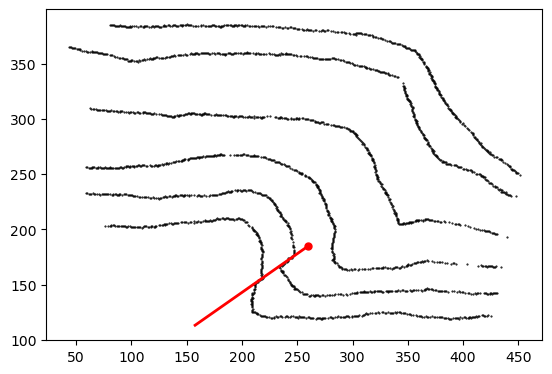

In [2]:
# read and plot the beds

beds = [] # list of beds
fig, ax = plt.subplots() # create a figure and axis

for i in range(1, 7):
    # read the bed file
    path = os.path.join("..", "data", "Catskill", f"bed{i}.txt")
    bed = np.loadtxt(path)
    bed[:,1] = 400 - bed[:,1] # flip the y coordinate
    # plot the bed
    ax.plot(bed[:, 0], bed[:, 1], "k.", markersize=1)
    # add the bed to the list
    beds.append(bed)

xtf, ytf = 260, 185 # fault tip
ramp = 35 * np.pi / 180 # ramp angle
xti = xtf - 125 * np.cos(ramp)
yti = ytf - 125 * np.sin(ramp)

# plot the fault
ax.plot([xtf, xti], [ytf, yti], "r-", lw=2)
ax.plot(xtf, ytf, "ro", markersize=5)

ax.set_aspect("equal")
plt.show()

For this structure, the fault tip location and fault dip (ramp angle) are known. Therefore, our objective is to determine the optimal combination of the following three parameters: P/S ratio, trishear angle, and fault slip.

We'll use bed 3 (the third bed from the base) and apply a brute-force grid search to explore the parameter space. The search will cover the following ranges:

| Parameter | Minimum | Maximum | Step |
|------|-----|----------------|------------|
| P/S ratio | 2.0 | 3.0 | 0.2 |
| Trishear angle (deg) | 30 | 50 | 2 |
| Fault slip | 200 | 500 | 5 |      

The step sizes are intentionally coarse to limit the total number of models—about 4,000 in total. 

The algorithm will systematically evaluate each parameter combination and identify the one that minimizes the objective function. This model is the one that best restores bed 3 to a straight line.

This method is simple but computationally demanding. Go ahead and run the cell below—then take a break; it will take about 30 minutes to complete!

In [3]:
# grid seach inversion

# use third bed from base
bed = beds[2]
xp, yp = bed[:, 0], bed[:, 1] # x and y coordinates of the bed

# boundaries of the search
# max, min, and step for each parameter
# xt, yt, ramp, ps, tra, slip, conc. factor
bounds = [[xtf, xtf, 0], [ytf, ytf, 0], [ramp, ramp, 0], 
          [2.0, 3.0, 0.2], 
          [30*np.pi/180, 50*np.pi/180, 2*np.pi/180],
          [200, 500, 5], [1.0, 1.0, 0]]

# slip increment
sinc = 1

start_time = time.time() # start timer

# run grid search inversion
tpar_best, chisq_min, chisq = grid_search(xp, yp, bounds, sinc)

end_time = time.time() # end timer

# output best P/S, trishear angle and slip
tpar = tpar_best[3:6]
tpar[1] = tpar[1] * 180 / np.pi # convert trishear angle to degrees
print(f"Best parameters: ps = {tpar[0]:.2f}, tra = {tpar[1]:.2f}, slip = {tpar[2]:.2f}")
print(f"Elapsed time = {(end_time - start_time)/60:.2f} minutes")

Total models: 4026
Model, [xt, yt, ramp, ps, tra, slip, c], chisq
1 ['260.00', '185.00', '0.61', '2.00', '0.52', '200.00', '1.00'] 32708.64
2 ['260.00', '185.00', '0.61', '2.00', '0.52', '205.00', '1.00'] 32396.91
3 ['260.00', '185.00', '0.61', '2.00', '0.52', '210.00', '1.00'] 32107.80
4 ['260.00', '185.00', '0.61', '2.00', '0.52', '215.00', '1.00'] 31837.09
5 ['260.00', '185.00', '0.61', '2.00', '0.52', '220.00', '1.00'] 31581.49
6 ['260.00', '185.00', '0.61', '2.00', '0.52', '225.00', '1.00'] 31338.37
7 ['260.00', '185.00', '0.61', '2.00', '0.52', '230.00', '1.00'] 31105.83
8 ['260.00', '185.00', '0.61', '2.00', '0.52', '235.00', '1.00'] 30881.96
9 ['260.00', '185.00', '0.61', '2.00', '0.52', '240.00', '1.00'] 30664.81
10 ['260.00', '185.00', '0.61', '2.00', '0.52', '245.00', '1.00'] 30452.59
11 ['260.00', '185.00', '0.61', '2.00', '0.52', '250.00', '1.00'] 30244.00
12 ['260.00', '185.00', '0.61', '2.00', '0.52', '255.00', '1.00'] 30037.83
13 ['260.00', '185.00', '0.61', '2.00', '0.

Although grid search is computationally inefficient, it has a key advantage: it provides a comprehensive view of the parameter space. This makes it valuable for understanding how model performance varies across different parameter combinations.

Let’s visualize the parameter space (the star is the best model):

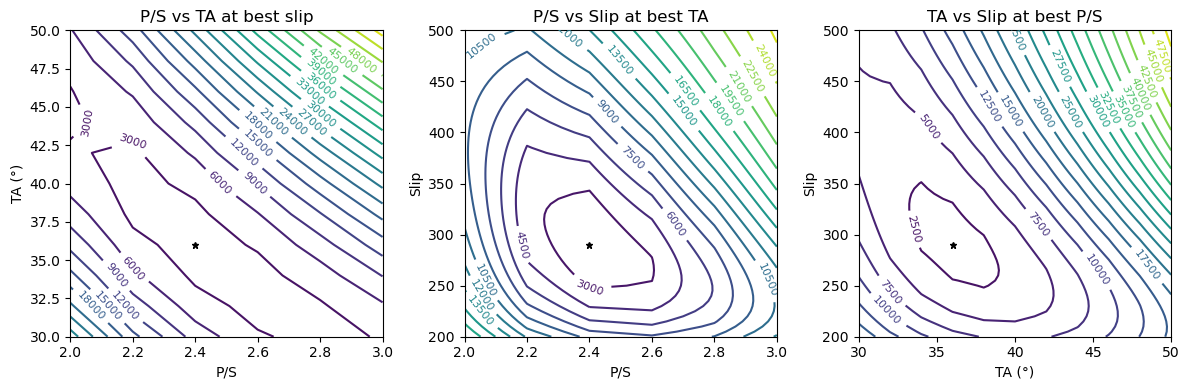

In [4]:
# parameter ranges
bounds_free = bounds[3:6]  # free parameters
ranges = []
for low, high, step in bounds_free:
    nels = int(round((high - low) / step)) + 1
    ranges.append(np.linspace(low, high, nels))

# convert trishear angle to degrees
ranges[1] = [r * 180 / np.pi for r in ranges[1]]

# minimum chisq and indices
min_index = np.unravel_index(np.argmin(chisq), chisq.shape)

# make these lists for easier plotting
slices = [chisq[:, :, min_index[2]], 
          chisq[:, min_index[1], :], 
          chisq[min_index[0], :, :]]
x_plots = [ranges[0], ranges[0], ranges[1]]
y_plots = [ranges[1], ranges[2], ranges[2]]
x_labels = ["P/S", "P/S", "TA (°)"]
y_labels = ["TA (°)", "Slip", "Slip"]
titles = ["P/S vs TA at best slip", 
          "P/S vs Slip at best TA", 
          "TA vs Slip at best P/S"]
x_best = [tpar[0], tpar[0], tpar[1]]
y_best = [tpar[1], tpar[2], tpar[2]]

# plot the chisq slices
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    # create a meshgrid for the contour plot
    XX, YY = np.meshgrid(x_plots[i], y_plots[i])
    
    # create the contour plot
    cs = ax[i].contour(XX, YY, slices[i].T, levels=20, cmap="viridis")
    
    # add labels to the contours
    ax[i].clabel(cs, inline=True, fontsize=8)
    
    # plot the best model
    ax[i].plot(x_best[i], y_best[i], "k*", markersize=5)
    
    # set axis labels and title
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_title(titles[i])

fig.tight_layout()
plt.show()

We observe that the solution is more tightly constrained for fault slip (approximately 290 units) compared to P/S and the trishear angle. Additionally, P/S and the trishear angle exhibit an inverse correlation: models with low P/S and high trishear angle, or high P/S and low trishear angle, tend to perform well.

Now, let’s use a more efficient approach. Trishear inverse modeling is fundamentally an optimization problem, and we can leverage numerical optimization algorithms to solve it more effectively.

Because the parameter space often contains multiple local minima, it's essential to use global optimization methods that can escape local traps and converge toward better solutions.

In the example below, we’ll use simulated annealing to search for the best-fit model, using the same parameter bounds defined earlier. Unlike the brute-force grid search, this method does not require a fixed step size, and it samples many possible solutions across the parameter space, allowing it to explore more freely and get much closer to the optimal result.

In [5]:
# simulated annealing inversion

# use third bed from base
bed = beds[2]
xp, yp = bed[:, 0], bed[:, 1] # x and y coordinates of the bed

# boundaries of the search
# max and min for each parameter
# xt, yt, ramp, ps, tra, slip, conc. factor
bounds = [(xtf, xtf), (ytf, ytf), (ramp, ramp), (2.0, 3.0),
          (30*np.pi/180, 50*np.pi/180), (200, 500), (1.0, 1.0)]

# slip increment
sinc = 1

start_time = time.time() # start timer

# run simulated annealing inversion
# use default annealing cycles and initial temperature
tpar_best, chisq_min, history = simulated_annealing(xp, yp, bounds, sinc)

end_time = time.time() # end timer

# output best P/S, trishear angle and slip
tpar = tpar_best[3:6]
tpar[1] = tpar[1] * 180 / np.pi # convert trishear angle to degrees
print(f"Best parameters: ps = {tpar[0]:.2f}, tra = {tpar[1]:.2f}, slip = {tpar[2]:.2f}")
print(f"Elapsed time = {(end_time - start_time)/60:.2f} minutes")

Model, [xt, yt, ramp, ps, tra, slip, c], chisq
1 ['260.00', '185.00', '0.61', '2.07', '0.74', '257.97', '1.00'] 2357.97
2 ['260.00', '185.00', '0.61', '2.45', '0.69', '205.35', '1.00'] 6365.64
3 ['260.00', '185.00', '0.61', '2.34', '0.67', '262.24', '1.00'] 1948.52
4 ['260.00', '185.00', '0.61', '2.37', '0.73', '470.69', '1.00'] 24316.79
5 ['260.00', '185.00', '0.61', '2.02', '0.67', '262.24', '1.00'] 7357.21
6 ['260.00', '185.00', '0.61', '2.34', '0.70', '262.24', '1.00'] 2210.85
7 ['260.00', '185.00', '0.61', '2.34', '0.70', '448.57', '1.00'] 16132.04
8 ['260.00', '185.00', '0.61', '2.43', '0.83', '268.70', '1.00'] 15978.76
9 ['260.00', '185.00', '0.61', '2.79', '0.83', '210.05', '1.00'] 28366.02
10 ['260.00', '185.00', '0.61', '2.88', '0.62', '214.78', '1.00'] 8143.46
11 ['260.00', '185.00', '0.61', '2.88', '0.70', '262.24', '1.00'] 16491.98
12 ['260.00', '185.00', '0.61', '2.34', '0.84', '262.24', '1.00'] 12634.94
13 ['260.00', '185.00', '0.61', '2.34', '0.70', '464.73', '1.00'] 17

This is significantly faster than grid search. Let's visualize the algorithm's path through the parameter space (the star is the best model):

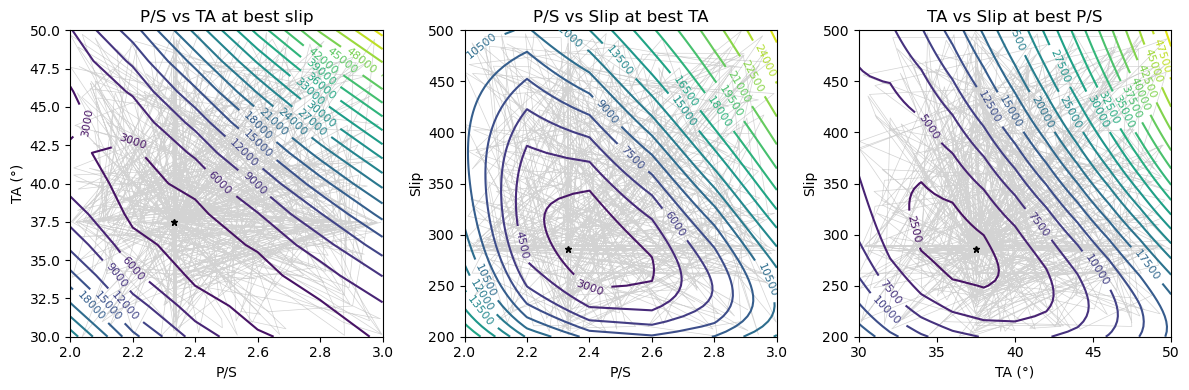

In [6]:
x_best = [tpar[0], tpar[0], tpar[1]]
y_best = [tpar[1], tpar[2], tpar[2]]
x_path = [history[:, 3], history[:, 3], history[:, 4] * 180 / np.pi]
y_path = [history[:, 4] * 180 / np.pi, history[:, 5], history[:, 5]]

# plot the chisq slices
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    # plot the path
    ax[i].plot(x_path[i], y_path[i], "-", color="lightgray", lw=0.5)

    # create a meshgrid for the contour plot
    XX, YY = np.meshgrid(x_plots[i], y_plots[i])
    
    # create the contour plot
    cs = ax[i].contour(XX, YY, slices[i].T, levels=20, cmap="viridis")
    
    # add labels to the contours
    ax[i].clabel(cs, inline=True, fontsize=8)

    # plot the best model
    ax[i].plot(x_best[i], y_best[i], "k*", markersize=5)
    
    # set axis labels and title
    ax[i].set_xlabel(x_labels[i])
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_title(titles[i])

fig.tight_layout()
plt.show()

Although the optimization path appears somewhat random, the algorithm effectively samples models with low objective function values. This is evident from the increased density of gray lines within the region enclosed by the lowest objective function contour.

Finally, we can restore the structure using the best-fit parameters obtained from either the grid-search or the optimization. In the example below, we use the optimization results:

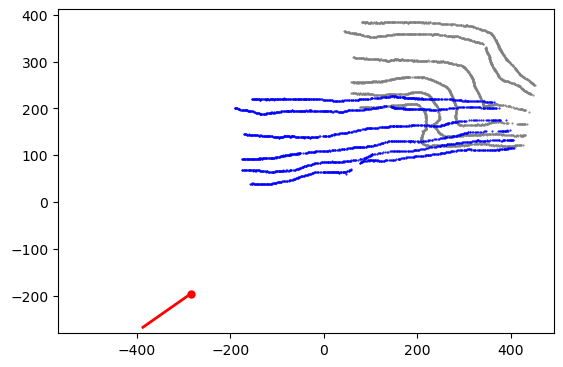

In [7]:
# restore the beds
beds_rest, xti, yti = restore_beds(beds, tpar_best, sinc)

And deform the initial beds to check how well the model fits the structure:

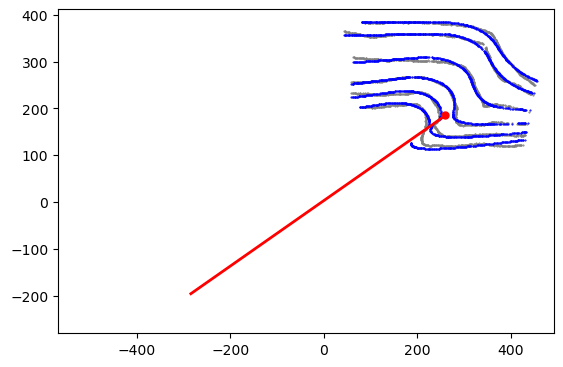

In [8]:
# trishear parameters for deforming the beds
tpar_def = tpar_best.copy()
tpar_def[0] = xti
tpar_def[1] = yti

# deform the beds
beds_def, xtf, ytf = deform_beds(beds_rest, beds, tpar_def, sinc)

The fit to bed 3, as well as to the other beds, is quite good. Overall, the model provides a reasonable respresentation of the data and can serve multiple purposes—for example, predicting the distribution of strain across the structure ([Allmendinger, 1998](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/98TC01907), his Figure 11c).

The optimized trishear inversion method enables analysis of how data uncertainties affect the inversion results and helps assess the non-uniqueness of the solution.
For more details, see [Cardozo and Aanonsen (2009)](https://www.sciencedirect.com/science/article/abs/pii/S0191814109000388) and [Cardozo et al. (2011)](https://www.sciencedirect.com/science/article/abs/pii/S0191814111000721).